# Lab 8 - Graph Data Analytics

Complete the code with TODO tag.

If you haven't installed networkx package, you can run the following command (note the exclamation mark)

```bash
!conda install networkx --yes
```

## 1. Centrality Analysis
In this exercise, you will implement the pagerank centrality.

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def pagerank_centrality(G, iter=100):
    p = np.array([1 for i in G.nodes()])
    top = 0
    
    for k in range(iter):
        for i in G.nodes():
            for j in G.nodes():
                # TODO: update the centrality
                p[i] += (1 if G.has_edge(i, j) else 0)
            if(p[i] > top):
                top = p[i]
        
        # TODO: Normalize the centrality value to avoid overflow of numerical computation
        norm = (top)
        p = p / norm        
    return p

G = nx.karate_club_graph()
print(nx.info(G))
values = pagerank_centrality(G)
nx.draw(G, cmap=plt.get_cmap('Reds'), node_color = values, with_labels=True)

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


C:\Users\Pube\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


## 2. Community Analysis

### 2.1. Clique Percolation Method

One well-known algorithm for detecting overlapping communities is called the Clique Percolation Method (CPM).

In [43]:
from itertools import combinations

def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    
    # TODO: find cliques of the graph
    cliques = nx.find_cliques(G)
    clist = []
    
    for c in cliques:
        if(k==len(c)):
            clist.append(frozenset(c))
            
    perc_graph.add_nodes_from(clist)
    
    # TODO: Add an edge in the clique graph for each pair of cliques that percolate
    for c1, c2 in combinations(cliques, 2):
        if len(c1.intersection(c2)) >= (k - 1):
            perc_graph.add_edge(c1, c2)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

Test with a small dataset

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
---0.0 seconds---


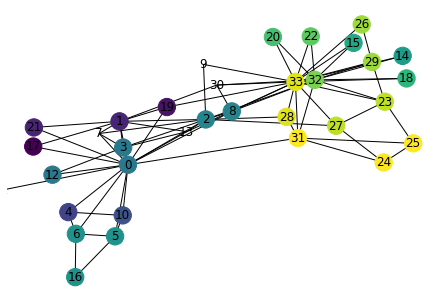

In [67]:
def partition(communities):
    node2communities = dict()
    com_list = list(communities)
    length = len(com_list)
    cur_col = 20;
    for i in range(length):
        com = com_list[i]
        for n in com:
            node2communities.update({n : cur_col})
        cur_col = cur_col + 200
    # TODO: transform the community information to partition assignment for data visualization
    return node2communities
            
G = nx.karate_club_graph()
print(nx.info(G))

import time
start_time = time.time()
communities = get_percolated_cliques(G,3)
print("---{0} seconds---".format(time.time() - start_time))
part = partition(communities)
values = [part.get(node) for node in G.nodes()]

nx.draw(G, node_color = values, with_labels=True)

### 2.2. Efficient Implementation
That implementation is correct but expensive---it requires O(N^2) clique comparisons, where N is the number of cliques (which is often much larger than the number of nodes!).  If we use a python dictionary to index which nodes belong to which cliques, then we can easily compare only those cliques that share at least one node in common.  This implementation is a bit longer but should be more efficient:

---0.0009975433349609375 seconds---


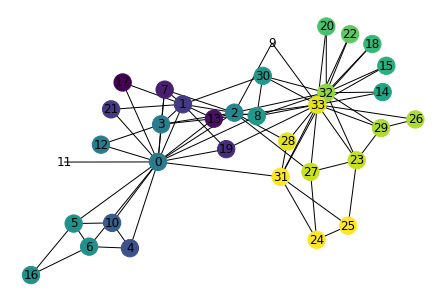

In [87]:
from collections import defaultdict

def get_percolated_cliques2(G, k):
    perc_graph = nx.Graph()
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    
    # TODO: get adjacent cliques
    for e in membership_dict[clique]:
        if(e != clique):
            adjacent_cliques.add(e)
    return adjacent_cliques

start_time = time.time()
communities = get_percolated_cliques2(G,3)
print("---{0} seconds---".format(time.time() - start_time))
part = partition(get_percolated_cliques2(G,3))

values = [part.get(node) for node in G.nodes()]

nx.draw(G, node_color = values, with_labels=True)

### 2.3. Test with large dataset

Now we test with a real large-scale network data at https://snap.stanford.edu/data/com-Amazon.html

In [89]:
#G = nx.read_edgelist("email-Eu-core.txt")
G = nx.read_edgelist("com-amazon.ungraph.txt")
print(nx.info(G))

start_time = time.time()
communities = get_percolated_cliques(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

start_time = time.time()
communities = get_percolated_cliques2(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

Name: 
Type: Graph
Number of nodes: 334863
Number of edges: 925872
Average degree:   5.5299
---0.003024578094482422 seconds---
---0.0 seconds---
